In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import itertools
from collections import defaultdict
import re


In [4]:
########### Load data ###########

training_sum = []
loss = []
molecule_error = []
root_dir = r"C:\Users\rikke\OneDrive - Danmarks Tekniske Universitet\Universitet\Kandidat - MMC\Deep Learning\Projekt\runs\grid_search\\"

best_training_sum = []
best_loss = []
best_molecule_error = []
best_models = r"C:\Users\rikke\OneDrive - Danmarks Tekniske Universitet\Universitet\Kandidat - MMC\Deep Learning\Projekt\runs\1000_epoch\\"


# Data for experiments
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith("summary.json"):
            full_path = os.path.join(dirpath, filename)
            training_sum.append(full_path)
        if filename.endswith("epoch.json"):
            full_path = os.path.join(dirpath, filename)
            loss.append(full_path)
        if filename.endswith("molecule_errors.json"):
            full_path = os.path.join(dirpath, filename)
            molecule_error.append(full_path)

#Data for best models
for dirpath, dirnames, filenames in os.walk(best_models):
    for filename in filenames:
        if filename.endswith("summary.json"):
            full_path = os.path.join(dirpath, filename)
            best_training_sum.append(full_path)
        if filename.endswith("epoch.json"):
            full_path = os.path.join(dirpath, filename)
            best_loss.append(full_path)
        if filename.endswith("molecule_errors.json"):
            full_path = os.path.join(dirpath, filename)
            best_molecule_error.append(full_path)

In [5]:
data_rows = []
best_data_rows = []

# Variables to extract from training summary JSON files
keys_to_extract = [
    "Test_MAE",
    "Total_time_seconds",
    "Best_train_loss",
    "Best_epoch",
    "Model_size_MB",
    "Subset_size",
    "Num_epochs",
    "Batch_size_train",
    "Batch_size_inference",
    "Learning_rate",
    "Weight_decay",
    "Num_message_passing_layers",
    "Num_features",
    "Num_outputs",
    "Num_rbf_features",
    "Num_unique_atoms",
    "Cutoff_distance",
    "Target",
    "Target_name"
]

# Training summeries for all runs
for file in training_sum:
    # Check if the file exists before trying to open it
    if not os.path.exists(file):
        print(f"File not found: {file}")
        continue
    # Load JSON data
    with open(file, "r") as f:
        data = json.load(f)

    row = {key: data.get(key, None) for key in keys_to_extract}
    row["Run"] = Path(file).parent.name

    data_rows.append(row)

for file in best_training_sum:
    # Check if the file exists before trying to open it
    if not os.path.exists(file):
        print(f"File not found: {file}")
        continue
    # Load JSON data
    with open(file, "r") as f:
        data = json.load(f)

    row = {key: data.get(key, None) for key in keys_to_extract}
    row["Run"] = Path(file).parent.name

    best_data_rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(data_rows)
best_df = pd.DataFrame(best_data_rows)

# Display or save
print(df.head())
print(best_df.head())

# Save the DataFrame to a CSV file
df.to_csv("training_summary.csv", index=False)
best_df.to_csv("best_training_summary.csv", index=False)

     Test_MAE  Total_time_seconds  Best_train_loss  Best_epoch  Model_size_MB  \
0    0.367834             2178.42         0.211714          97           0.24   
1  108.904816             2367.64         0.018676          94           0.24   
2   26.427822             2333.17         0.001678          98           0.24   
3    0.291082             2377.52         0.117534          98           0.24   
4   90.272011             2665.91         0.012534          99           0.24   

  Subset_size  Num_epochs  Batch_size_train  Batch_size_inference  \
0        None         100               100                  1000   
1        None         100               100                  1000   
2        None         100               100                  1000   
3        None         100               100                  1000   
4        None         100               100                  1000   

   Learning_rate  Weight_decay  Num_message_passing_layers  Num_features  \
0         0.0005      

In [6]:
# Filter rows where Target == 7
target_7= df[df["Target"] == 7]

# Save to a new CSV file
target_7.to_csv("training_summary_target_7.csv", index=False)

# Filter rows where Target == 0
target_0 = df[df["Target"] == 0]

# Save to a new CSV file
target_0.to_csv("training_summary_target_0.csv", index=False)

# Filter rows where Target == 2
target_2 = df[df["Target"] == 2]

# Save to a new CSV file
target_2.to_csv("training_summary_target_2.csv", index=False)


In [7]:
# Dictionary to store errors per molecule
error_dict = defaultdict(dict)

for file in molecule_error:
    file_path = Path(file)

    if not file_path.exists():
        print(f"[Missing] {file}")
        continue

    with open(file_path, "r") as f:
        data = json.load(f)

    molecule_index = data.get("molecule_indices")
    absolute_error = data.get("abs_errors")

    if molecule_index is None or absolute_error is None:
        print(f"[Missing keys] in {file}")
        continue

    if len(molecule_index) != len(absolute_error):
        print(f"[Length mismatch] in {file}")
        continue

    # Use the immediate parent folder name as the label
    run_name = file_path.parent.name

    for i in range(len(molecule_index)):
        idx = molecule_index[i]
        err = absolute_error[i]
        error_dict[idx][run_name] = err

# Convert to DataFrame
df_errors = pd.DataFrame.from_dict(error_dict, orient="index")
df_errors.index.name = "molecule_index"

print(df_errors.head())


                20250503_100042_target_0_layers_1_features_64_rbf_16_cutoff_4.0  \
molecule_index                                                                    
0                                                        0.433243                 
1                                                        1.318097                 
2                                                        1.075310                 
3                                                        0.472077                 
4                                                        0.196110                 

                20250503_103716_target_2_layers_1_features_64_rbf_16_cutoff_4.0  \
molecule_index                                                                    
0                                                        0.204658                 
1                                                        0.067045                 
2                                                        0.048331                 
3  

In [8]:
# Dictionary to store run_name → list of losses
loss_dict = {}

for file in loss:
    file_path = Path(file)

    if not file_path.exists():
        print(f"[Missing] {file}")
        continue

    # Read the loss file (list of floats)
    with open(file_path, "r") as f:
        try:
            loss_list = json.load(f)
        except Exception as e:
            print(f"[Error loading JSON] {file}: {e}")
            continue

    # Validate format
    if not isinstance(loss_list, list) or not all(isinstance(x, (float, int)) for x in loss_list):
        print(f"[Invalid format] {file}")
        continue

    # Use the subfolder name as the run identifier
    run_name = file_path.parent.name
    loss_dict[run_name] = loss_list

# Create a DataFrame: rows = runs, columns = epochs
df_losses = pd.DataFrame.from_dict(loss_dict, orient="index")
df_losses.columns = [f"epoch_{i+1}" for i in range(df_losses.shape[1])]
df_losses.index.name = "run"

# Transpose: rows = epochs, columns = runs
df_losses_transposed = df_losses.T
df_losses_transposed.index.name = "epoch"

# Show the result
print(df_losses_transposed.head())


run      20250503_100042_target_0_layers_1_features_64_rbf_16_cutoff_4.0  \
epoch                                                                      
epoch_1                                           1.271550                 
epoch_2                                           0.835379                 
epoch_3                                           0.700628                 
epoch_4                                           0.634576                 
epoch_5                                           0.587820                 

run      20250503_103716_target_2_layers_1_features_64_rbf_16_cutoff_4.0  \
epoch                                                                      
epoch_1                                           0.304993                 
epoch_2                                           0.147426                 
epoch_3                                           0.112088                 
epoch_4                                           0.093938                 
epoch_5    

In [9]:
print(df.columns)


Index(['Test_MAE', 'Total_time_seconds', 'Best_train_loss', 'Best_epoch',
       'Model_size_MB', 'Subset_size', 'Num_epochs', 'Batch_size_train',
       'Batch_size_inference', 'Learning_rate', 'Weight_decay',
       'Num_message_passing_layers', 'Num_features', 'Num_outputs',
       'Num_rbf_features', 'Num_unique_atoms', 'Cutoff_distance', 'Target',
       'Target_name', 'Run'],
      dtype='object')


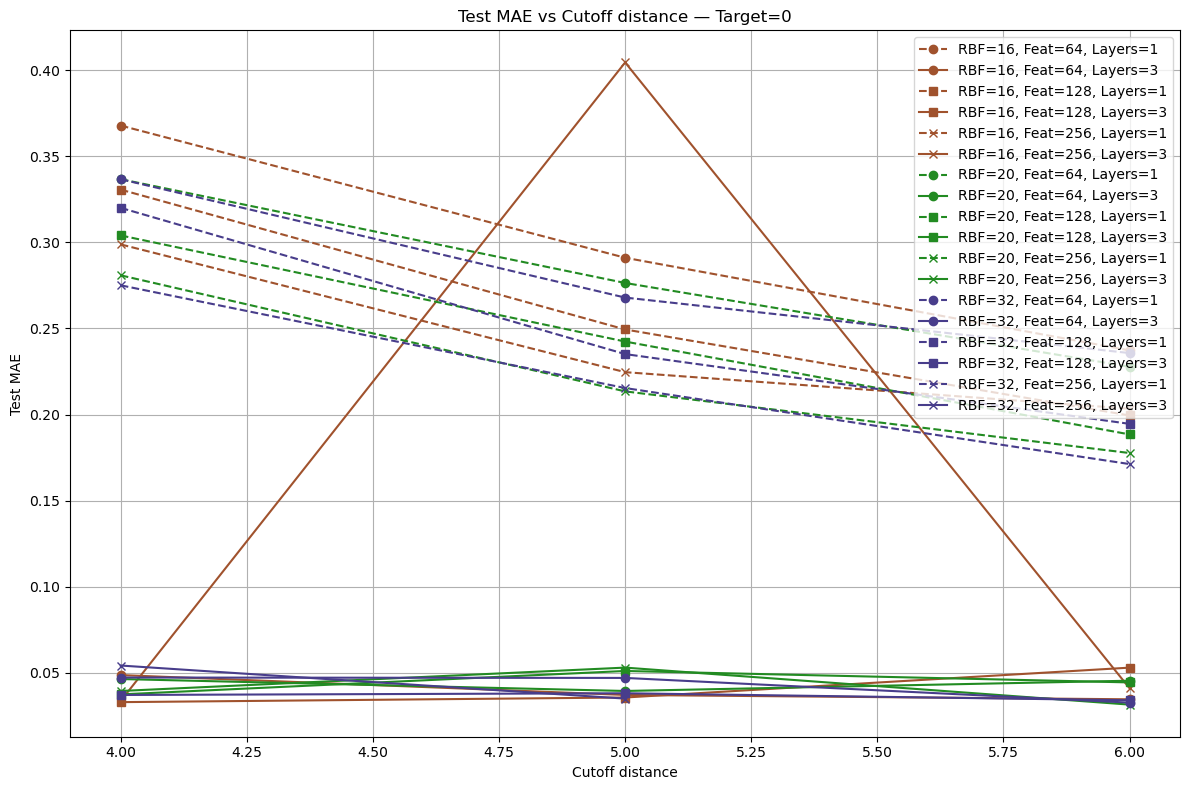

In [10]:
################### Target 0 ###################

# Define style cycles
colors = ['sienna', 'forestgreen','darkslateblue']
markers = ['o', 's', 'x']
linestyles = ['dashed', 'solid']

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target for this plot
fixed_target = 0

# Create combinations of styles
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
    df["Num_message_passing_layers"].unique(),
)

for num_rbf, num_features, num_layers in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == num_layers) &  
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Num_features")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]
    linestyle = linestyles[list(df["Num_message_passing_layers"].unique()).index(num_layers) % len(linestyles)]


    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={num_layers}",
        marker=marker,
        color=color,
        linestyle=linestyle,
    )

plt.xlabel("Cutoff distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


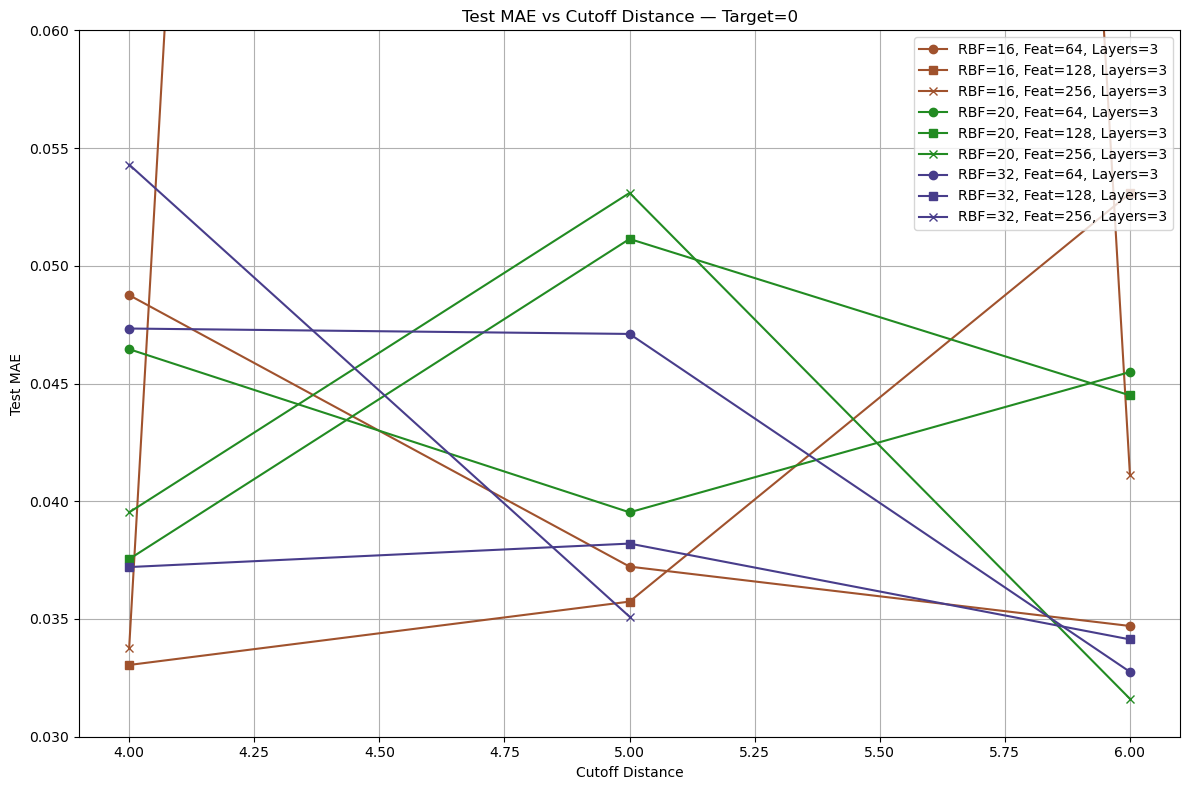

In [11]:
################### Target 0 - Zoomed in ###################

# Define style cycles
colors = ['sienna', 'forestgreen', 'darkslateblue']
markers = ['o', 's', 'x']
linestyles = ['solid'] 

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target and layer for this plot
fixed_target = 0
fixed_layer = 3

# Create combinations only for layer = 3
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
)

for num_rbf, num_features in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == fixed_layer) &
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Cutoff_distance")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]

    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={fixed_layer}",
        marker=marker,
        color=color,
    linestyle='solid',
    )

plt.xlabel("Cutoff Distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff Distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(0.030, 0.060)
plt.tight_layout()
plt.show()


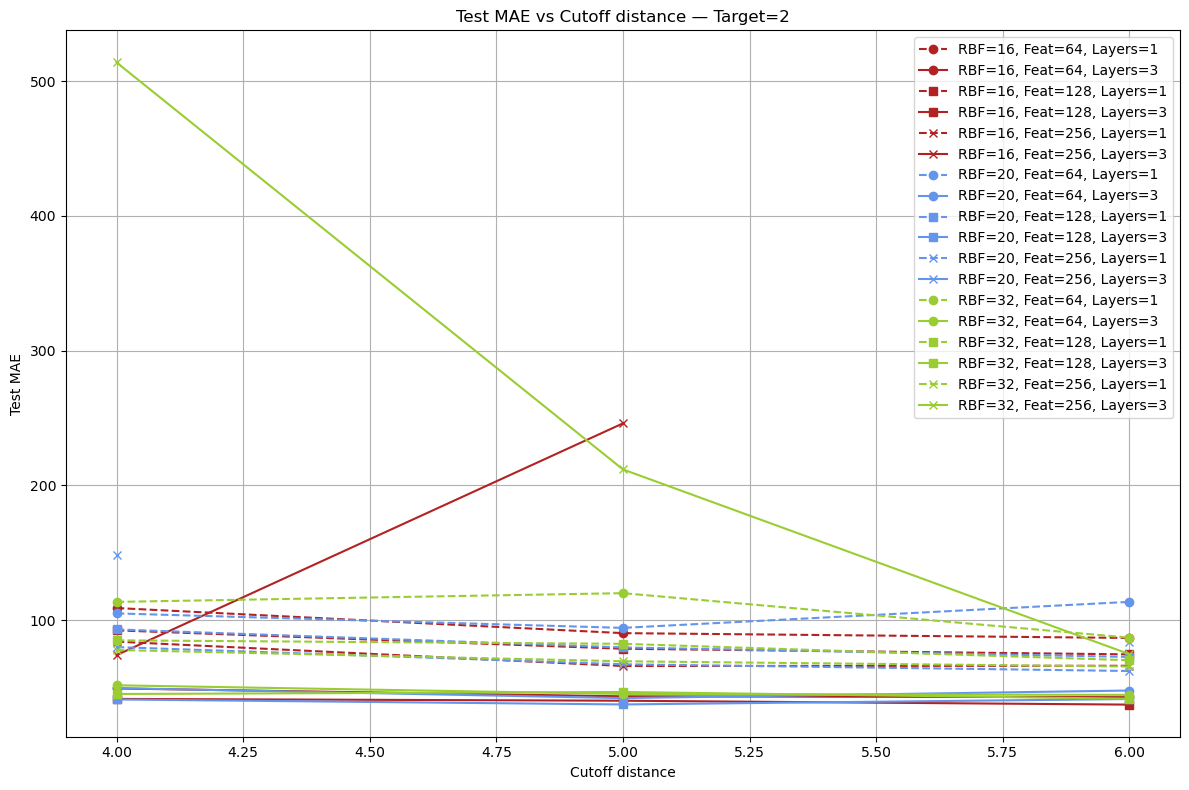

In [12]:
####### Target 2 ########


# Define style cycles
colors = ['firebrick','cornflowerblue', 'yellowgreen' ]
markers = ['o', 's', 'x']
linestyles = ['dashed', 'solid']

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target for this plot
fixed_target = 2

# Create combinations of styles
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
    df["Num_message_passing_layers"].unique(),
)

for num_rbf, num_features, num_layers in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == num_layers) &  
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Num_features")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]
    linestyle = linestyles[list(df["Num_message_passing_layers"].unique()).index(num_layers) % len(linestyles)]


    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={num_layers}",
        marker=marker,
        color=color,
        linestyle=linestyle,
    )

plt.xlabel("Cutoff distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()



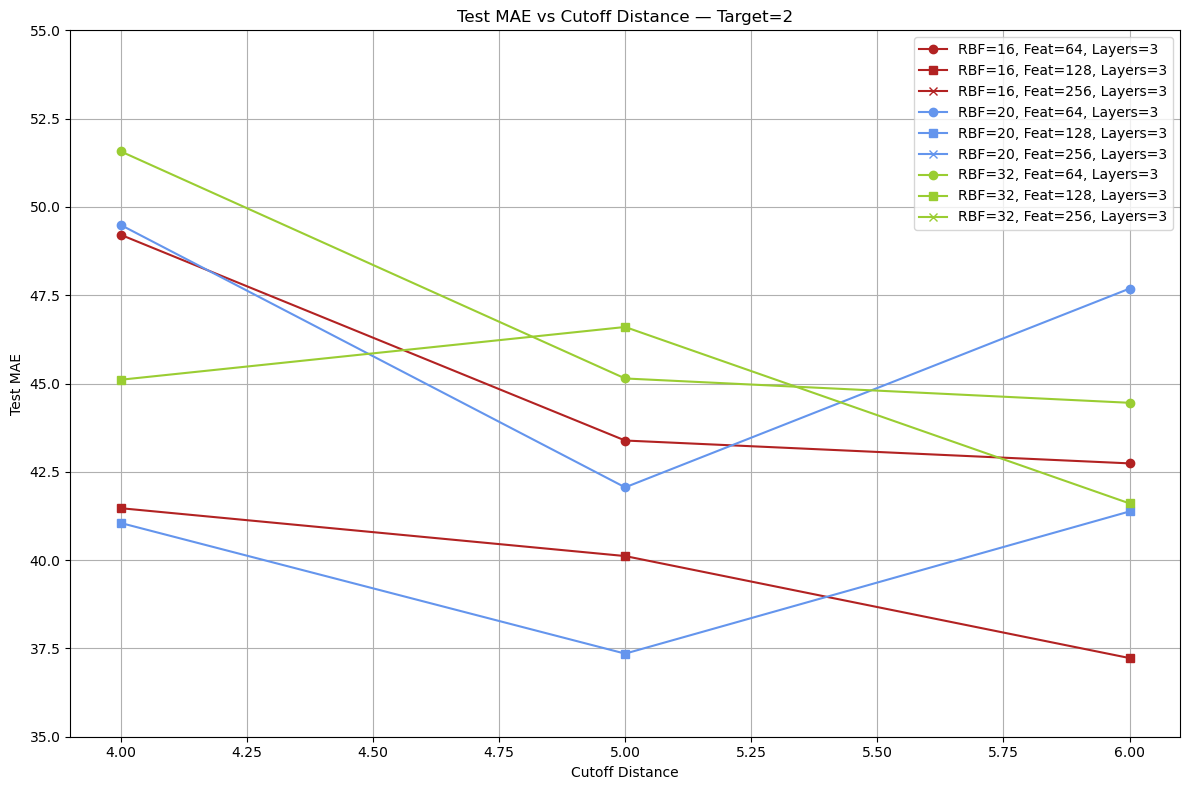

In [13]:
####### Target 2 - Zoomed in ######


# Define style cycles
colors = ['firebrick','cornflowerblue', 'yellowgreen' ]
markers = ['o', 's', 'x']
linestyles = ['solid'] 

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target and layer for this plot
fixed_target = 2
fixed_layer = 3

# Create combinations only for layer = 3
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
)

for num_rbf, num_features in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == fixed_layer) &
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Cutoff_distance")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]

    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={fixed_layer}",
        marker=marker,
        color=color,
    linestyle='solid',
    )

plt.xlabel("Cutoff Distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff Distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(35, 55)
plt.tight_layout()
plt.show()



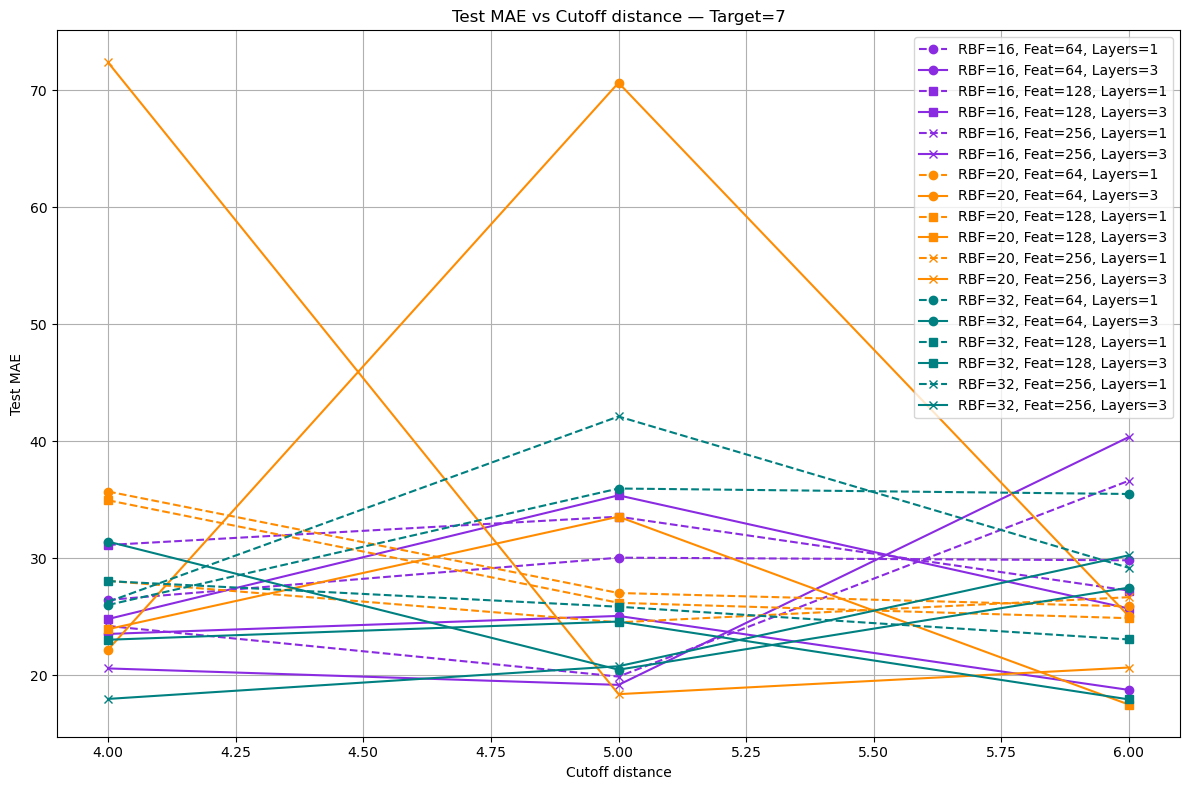

In [14]:
####### Target 7 ########

# Define style cycles
colors = ['blueviolet', 'darkorange', 'teal']
markers = ['o', 's', 'x']
linestyles = ['dashed', 'solid']

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target for this plot
fixed_target = 7

# Create combinations of styles
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
    df["Num_message_passing_layers"].unique(),
)

for num_rbf, num_features, num_layers in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == num_layers) &  
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Num_features")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]
    linestyle = linestyles[list(df["Num_message_passing_layers"].unique()).index(num_layers) % len(linestyles)]


    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={num_layers}",
        marker=marker,
        color=color,
        linestyle=linestyle,
    )

plt.xlabel("Cutoff distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


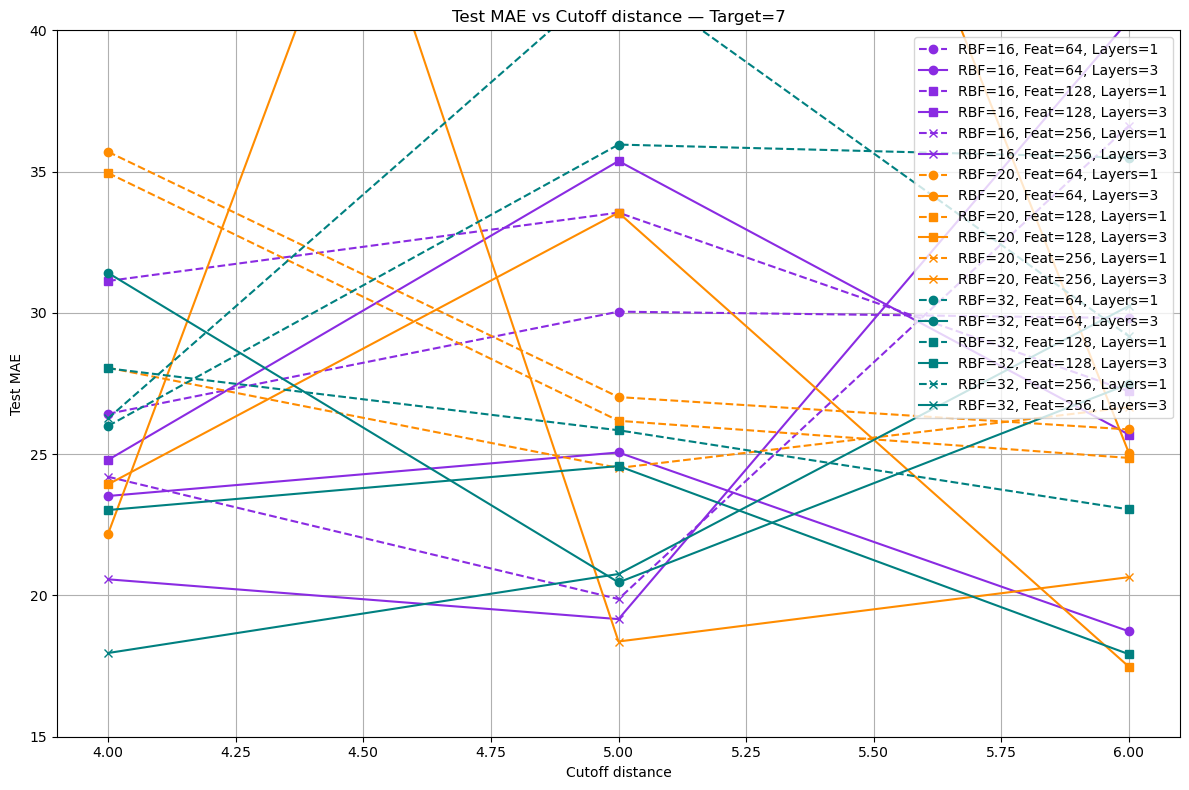

In [15]:
####### Target 7 ########

# Define style cycles
colors = ['blueviolet', 'darkorange', 'teal']
markers = ['o', 's', 'x']
linestyles = ['dashed', 'solid']

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fix the target for this plot
fixed_target = 7

# Create combinations of styles
style_combinations = itertools.product(
    df["Num_rbf_features"].unique(),
    df["Num_features"].unique(),
    df["Num_message_passing_layers"].unique(),
)

for num_rbf, num_features, num_layers in style_combinations:
    subset = df[
        (df["Num_rbf_features"] == num_rbf) &
        (df["Num_features"] == num_features) &
        (df["Num_message_passing_layers"] == num_layers) &  
        (df["Target"] == fixed_target)
    ]
    if subset.empty:
        continue
    subset = subset.sort_values("Num_features")

    color = colors[list(df["Num_rbf_features"].unique()).index(num_rbf) % len(colors)]
    marker = markers[list(df["Num_features"].unique()).index(num_features) % len(markers)]
    linestyle = linestyles[list(df["Num_message_passing_layers"].unique()).index(num_layers) % len(linestyles)]


    plt.plot(
        subset["Cutoff_distance"],
        subset["Test_MAE"],
        label=f"RBF={num_rbf}, Feat={num_features}, Layers={num_layers}",
        marker=marker,
        color=color,
        linestyle=linestyle,
    )

plt.xlabel("Cutoff distance")
plt.ylabel("Test MAE")
plt.title(f"Test MAE vs Cutoff distance — Target={fixed_target}")
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(15,40)
plt.tight_layout()
plt.show()


In [16]:
Best_runs = df.loc[df.groupby("Target")["Test_MAE"].idxmin()]
print(Best_runs)


      Test_MAE  Total_time_seconds  Best_train_loss  Best_epoch  \
150   0.031609             7588.92         0.001805          64   
115  37.227024             4058.04         0.001246          94   
125  17.475294             3987.44         0.000908          93   

     Model_size_MB Subset_size  Num_epochs  Batch_size_train  \
150           9.12        None         100               100   
115           2.35        None         100               100   
125           2.37        None         100               100   

     Batch_size_inference  Learning_rate  Weight_decay  \
150                  1000         0.0005          0.01   
115                  1000         0.0005          0.01   
125                  1000         0.0005          0.01   

     Num_message_passing_layers  Num_features  Num_outputs  Num_rbf_features  \
150                           3           256            1                20   
115                           3           128            1                16   
1

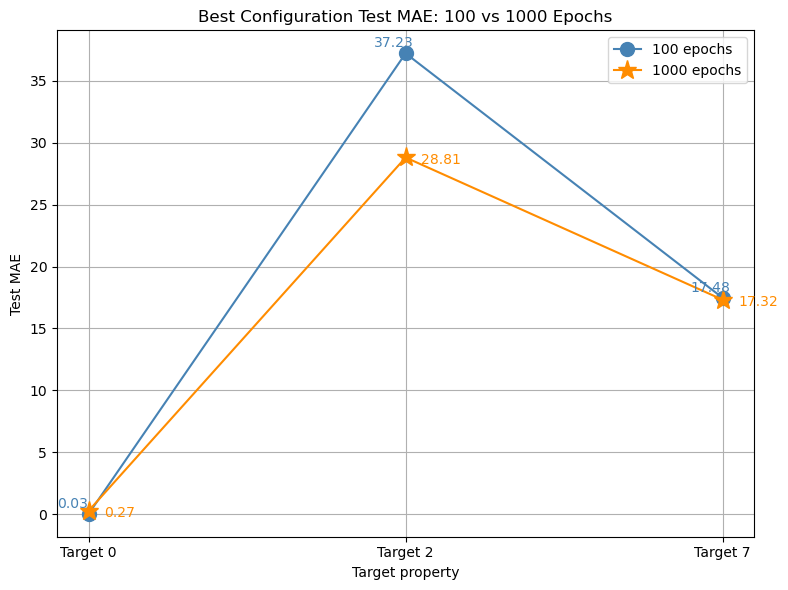

In [17]:
import matplotlib.pyplot as plt

# Set up data holders
targets = [0, 2, 7]
target_labels = ['Target 0', 'Target 2', 'Target 7']
test_mae_100 = []
test_mae_1000 = []

# Collect data
for i, target in enumerate(targets):
    # 1000-epoch best
    best_1000 = best_df.iloc[i]
    test_mae_1000.append(best_1000["Test_MAE"])

    # Matching 100-epoch config from df
    match = df[
        (df["Target"] == target) &
        (df["Num_features"] == best_1000["Num_features"]) &
        (df["Num_rbf_features"] == best_1000["Num_rbf_features"]) &
        (df["Num_message_passing_layers"] == best_1000["Num_message_passing_layers"]) &
        (df["Cutoff_distance"] == best_1000["Cutoff_distance"])
    ]
    if not match.empty:
        test_mae_100.append(match.iloc[0]["Test_MAE"])
    else:
        test_mae_100.append(None)

# Plot
x = range(len(targets))
plt.figure(figsize=(8, 6))

plt.plot(x, test_mae_100, 'o-', label="100 epochs", color="steelblue", markersize=10)
plt.plot(x, test_mae_1000, '*-', label="1000 epochs", color="darkorange", markersize=14)

# Annotate each point
for i in x:
    if test_mae_100[i] is not None:
        plt.text(i - 0.1, test_mae_100[i] + 0.5, f"{test_mae_100[i]:.2f}", color="steelblue", fontsize=10)
    plt.text(i + 0.05, test_mae_1000[i] - 0.5, f"{test_mae_1000[i]:.2f}", color="darkorange", fontsize=10)

plt.xticks(ticks=x, labels=target_labels)
plt.xlabel("Target property")
plt.ylabel("Test MAE")
plt.title("Best Configuration Test MAE: 100 vs 1000 Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


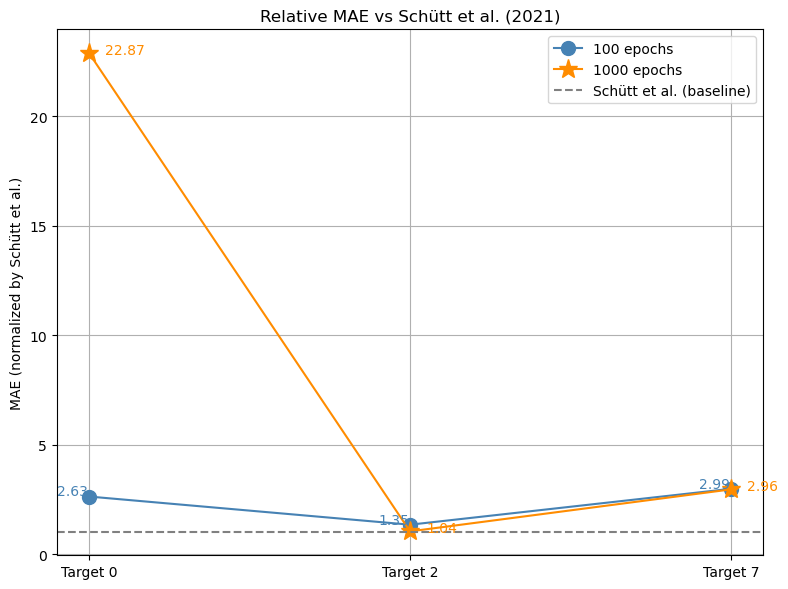

In [18]:
# Schütt MAE baseline
schuett_mae = [0.012, 27.6, 5.85]

# Normalize all MAEs
norm_mae_100 = [test_mae_100[i] / schuett_mae[i] for i in x]
norm_mae_1000 = [test_mae_1000[i] / schuett_mae[i] for i in x]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, norm_mae_100, 'o-', label="100 epochs", color="steelblue", markersize=10)
plt.plot(x, norm_mae_1000, '*-', label="1000 epochs", color="darkorange", markersize=14)
plt.axhline(1.0, color="gray", linestyle="--", label="Schütt et al. (baseline)")

# Annotations
for i in x:
    plt.text(i - 0.1, norm_mae_100[i] + 0.05, f"{norm_mae_100[i]:.2f}", color="steelblue")
    plt.text(i + 0.05, norm_mae_1000[i] - 0.05, f"{norm_mae_1000[i]:.2f}", color="darkorange")

plt.xticks(ticks=x, labels=target_labels)
plt.ylabel("MAE (normalized by Schütt et al.)")
plt.title("Relative MAE vs Schütt et al. (2021)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


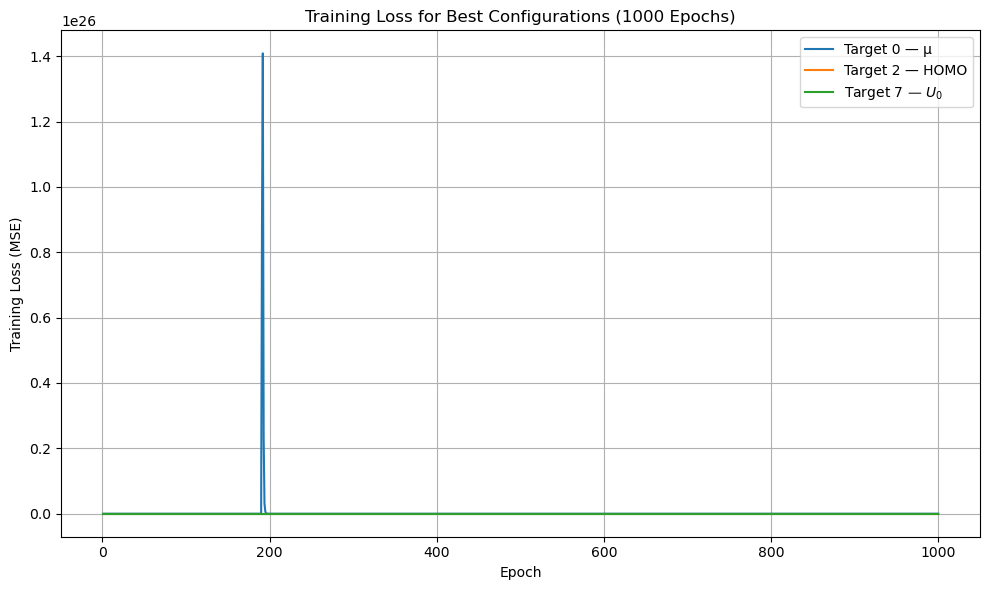

In [19]:
train_loss_files = {
    "Target 0 — μ": rf"{best_models}\20250511_163648_target_0_layers_3_lr_0.0005_features_256_rbf_20_cutoff_6.0\train_loss_per_epoch.json",
    "Target 2 — HOMO": rf"{best_models}\20250511_163648_target_2_layers_3_lr_0.0005_features_128_rbf_16_cutoff_6.0\train_loss_per_epoch.json",
    "Target 7 — $U_0$": rf"{best_models}\20250512_063504_target_7_layers_3_lr_0.0005_features_128_rbf_20_cutoff_6.0\train_loss_per_epoch.json",
}

# === Load training losses ===
train_losses = {}

for label, path in train_loss_files.items():
    with open(path, "r") as f:
        train_losses[label] = json.load(f)

# === Plot ===
plt.figure(figsize=(10, 6))

for label, loss_values in train_losses.items():
    epochs = list(range(1, len(loss_values) + 1))
    plt.plot(epochs, loss_values, label=label)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss for Best Configurations (1000 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


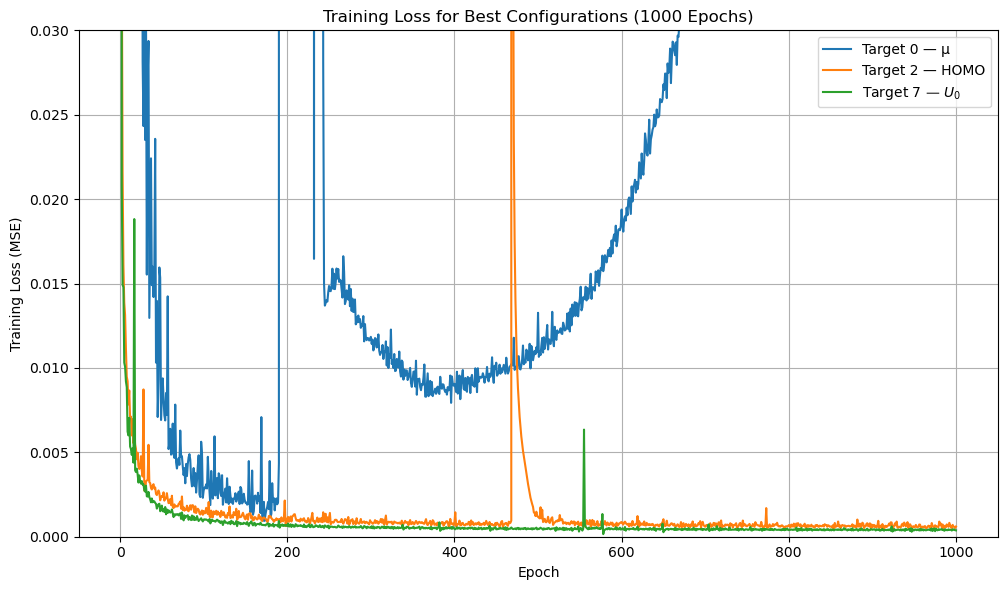

In [25]:
train_loss_files = {
    "Target 0 — μ": rf"{best_models}\20250511_163648_target_0_layers_3_lr_0.0005_features_256_rbf_20_cutoff_6.0\train_loss_per_epoch.json",
    "Target 2 — HOMO": rf"{best_models}\20250511_163648_target_2_layers_3_lr_0.0005_features_128_rbf_16_cutoff_6.0\train_loss_per_epoch.json",
    "Target 7 — $U_0$": rf"{best_models}\20250512_063504_target_7_layers_3_lr_0.0005_features_128_rbf_20_cutoff_6.0\train_loss_per_epoch.json",
}

# === Load training losses ===
train_losses = {}

for label, path in train_loss_files.items():
    with open(path, "r") as f:
        train_losses[label] = json.load(f)

# === Plot ===
plt.figure(figsize=(10, 6))

for label, loss_values in train_losses.items():
    epochs = list(range(1, len(loss_values) + 1))
    plt.plot(epochs, loss_values, label=label)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss for Best Configurations (1000 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.03)
plt.show()


<Figure size 1000x600 with 0 Axes>

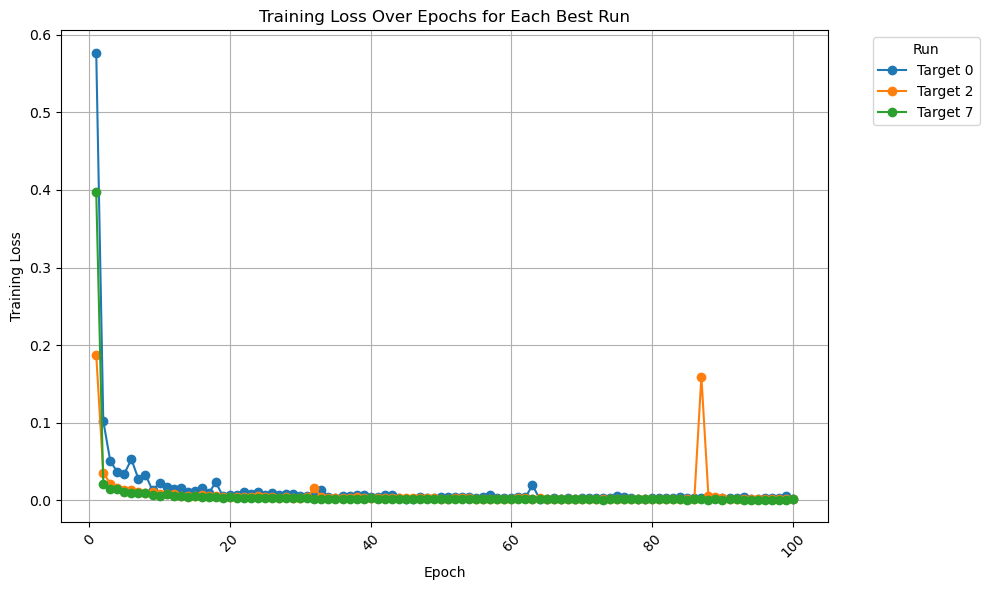

In [20]:
target_0_best_dir = r'C:\Users\rikke\OneDrive - Danmarks Tekniske Universitet\Universitet\Kandidat - MMC\Deep Learning\Projekt\runs\grid_search\20250506_140303_target_0_features_256_cutoff_6.0'
target_2_best_dir = r'C:\Users\rikke\OneDrive - Danmarks Tekniske Universitet\Universitet\Kandidat - MMC\Deep Learning\Projekt\runs\grid_search\20250505_123612_target_2_rbf_16_cutoff_6.0'
target_7_best_dir = r'C:\Users\rikke\OneDrive - Danmarks Tekniske Universitet\Universitet\Kandidat - MMC\Deep Learning\Projekt\runs\grid_search\20250505_180119_cutoff_6.0'



# Load the best run's loss data
target_0_best_loss_path = os.path.join(target_0_best_dir, "train_loss_per_epoch.json")
target_2_best_loss_path = os.path.join(target_2_best_dir, "train_loss_per_epoch.json") 
target_7_best_loss_path = os.path.join(target_7_best_dir, "train_loss_per_epoch.json")
with open(target_0_best_loss_path, "r") as f:
    target_0_best_loss = json.load(f)
with open(target_2_best_loss_path, "r") as f:
    target_2_best_loss = json.load(f)
with open(target_7_best_loss_path, "r") as f:
    target_7_best_loss = json.load(f)

# Create a DataFrame for the loss data
loss_data = {
    "Epoch": list(range(1, len(target_0_best_loss) + 1)),
    "Target 0": target_0_best_loss,
    "Target 2": target_2_best_loss,
    "Target 7": target_7_best_loss
}

# Plot each run's loss over epochs
plt.figure(figsize=(10, 6))
# Plot each run's loss over epochs (excluding the "Epoch" key)
plt.figure(figsize=(10, 6))
for target in ["Target 0", "Target 2", "Target 7"]:
    plt.plot(loss_data["Epoch"], loss_data[target], label=target, marker='o')



plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs for Each Best Run")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate epoch labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

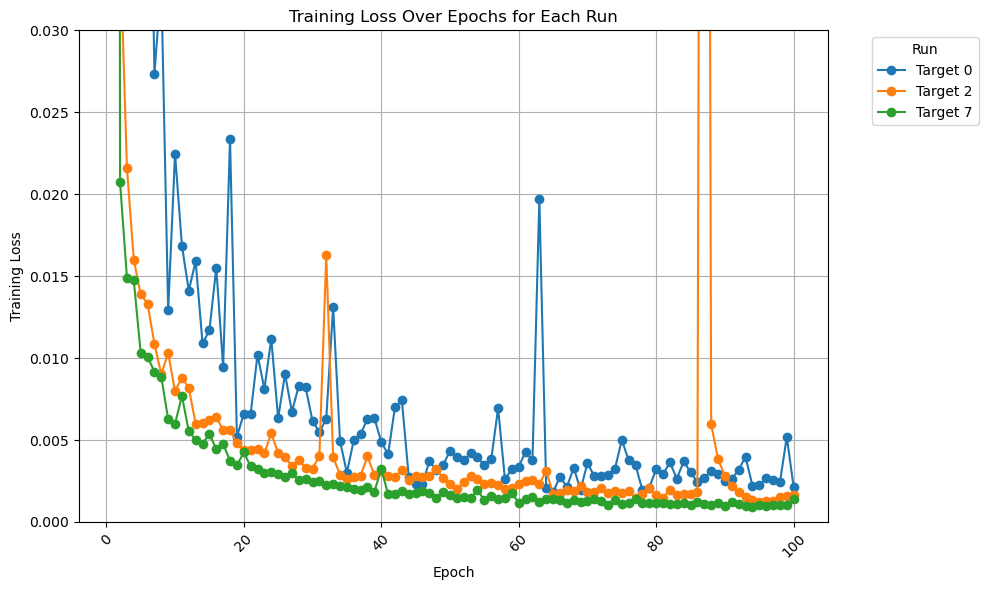

In [21]:
# Plot each run's loss over epochs
plt.figure(figsize=(10, 6))
# Plot each run's loss over epochs (excluding the "Epoch" key)
plt.figure(figsize=(10, 6))
for target in ["Target 0", "Target 2", "Target 7"]:
    plt.plot(loss_data["Epoch"], loss_data[target], label=target, marker='o')



plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs for Each Run")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate epoch labels for readability
plt.grid(True)
plt.ylim(0, 0.03)
plt.tight_layout()
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
C:\Users\rikke\AppData\Local\Temp\ipykernel_18788\4094430277.py:20: SyntaxWarning: invalid escape sequence '\p'
  "Target 0": f"{target_0_best_dir}\per_molecule_errors.json",
C:\Users\rikke\AppData\Local\Temp\ipykernel_18788\4094430277.py:21: SyntaxWarning: invalid escape sequence '\p'
  "Target 2": f"{target_2_best_dir}\per_molecule_errors.json",
C:\Users\rikke\AppData\Local\Temp\ipykernel_18788\4094430277.py:22: SyntaxWarning: invalid escape sequence '\p'
  "Target 7": f"{target_7_best_dir}\per_molecule_errors.json"



Processing Target 0...
Failed to convert molecule: Explicit valence for atom # 3 H, 2, is greater than permitted
Skipping molecule at index 2865 due to conversion failure.
Failed to convert molecule: Explicit valence for atom # 0 O, 3, is greater than permitted
Skipping molecule at index 3775 due to conversion failure.
Failed to convert molecule: Explicit valence for atom # 1 N, 4, is greater than permitted
Skipping molecule at index 3256 due to conversion failure.
Failed to convert molecule: Explicit valence for atom # 0 N, 4, is greater than permitted
Skipping molecule at index 9387 due to conversion failure.


[08:51:17] Explicit valence for atom # 3 H, 2, is greater than permitted
[08:51:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[08:51:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[08:51:17] Explicit valence for atom # 0 N, 4, is greater than permitted


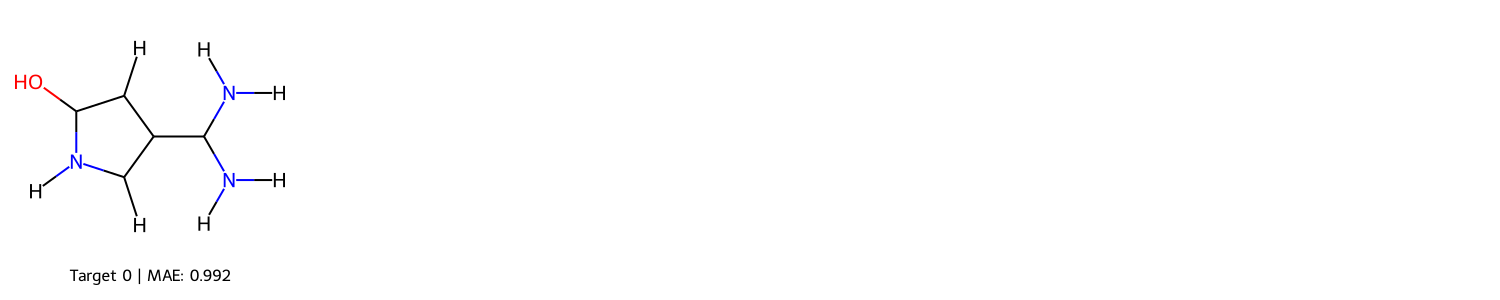


Processing Target 2...
Failed to convert molecule: Explicit valence for atom # 3 H, 2, is greater than permitted
Skipping molecule at index 2865 due to conversion failure.
Failed to convert molecule: Explicit valence for atom # 0 O, 3, is greater than permitted
Skipping molecule at index 3775 due to conversion failure.
Failed to convert molecule: Explicit valence for atom # 1 N, 4, is greater than permitted
Skipping molecule at index 3256 due to conversion failure.


[08:51:17] Explicit valence for atom # 3 H, 2, is greater than permitted
[08:51:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[08:51:17] Explicit valence for atom # 1 N, 4, is greater than permitted


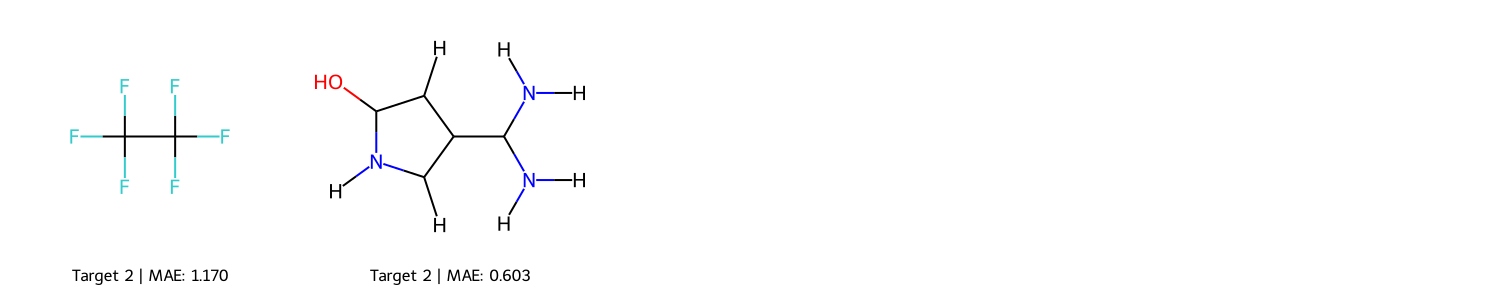


Processing Target 7...
Failed to convert molecule: Explicit valence for atom # 3 H, 2, is greater than permitted
Skipping molecule at index 2865 due to conversion failure.


[08:51:17] Explicit valence for atom # 3 H, 2, is greater than permitted


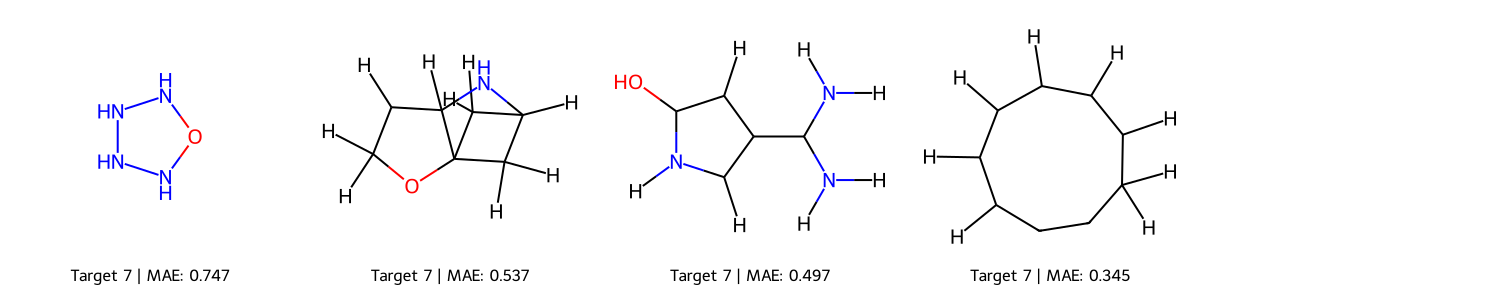

In [22]:
import torch
import numpy as np
import json
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import Mol
from typing import Optional
from IPython.display import display
import matplotlib.pyplot as plt


# === SETTINGS ===
seed = 0
splits = [110000, 10000, 10831]
data_root = "data/"

error_file_paths = {
    "Target 0": f"{target_0_best_dir}\per_molecule_errors.json",
    "Target 2": f"{target_2_best_dir}\per_molecule_errors.json",
    "Target 7": f"{target_7_best_dir}\per_molecule_errors.json"
}


# === Helper to convert torch_geometric Data to RDKit Mol ===
def geom_to_rdkit_mol(data: Data) -> Optional[Mol]:
    try:
        mol = Chem.RWMol()
        atom_map = {}
        for i, z in enumerate(data.z.tolist()):
            atom = Chem.Atom(int(z))
            idx = mol.AddAtom(atom)
            atom_map[i] = idx

        pos = data.pos
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                dist = (pos[i] - pos[j]).norm().item()
                if dist < 1.7:  # crude bonding rule
                    mol.AddBond(atom_map[i], atom_map[j], Chem.BondType.SINGLE)

        mol = mol.GetMol()
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(f"Failed to convert molecule: {e}")
        return None


# === Load dataset and permuted test indices ===
dataset = QM9(root=data_root)
rng = np.random.default_rng(seed=seed)
permuted_indices = rng.permutation(len(dataset))
test_start = sum(splits[:2])
test_indices = permuted_indices[test_start:]


# === Process each model ===
for model_name, path in error_file_paths.items():
    print(f"\nProcessing {model_name}...")

    with open(path) as f:
        errors = json.load(f)

    abs_errors = errors["abs_errors"]
    sorted_indices = sorted(range(len(abs_errors)), key=lambda i: -abs_errors[i])[:5]

    mols = []
    legends = []

    for i in sorted_indices:
        original_idx = test_indices[i]
        data = dataset[original_idx]
        mol = geom_to_rdkit_mol(data)

        if mol:
            mols.append(mol)
            legends.append(f"{model_name} | MAE: {abs_errors[i]:.3f}")
        else:
            print(f"Skipping molecule at index {i} due to conversion failure.")

    # === Visualize ===
    if mols:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=5,
            subImgSize=(300, 300),
            legends=legends,
            useSVG=False
        )
        display(img)
